In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import SelectKBest, f_regression

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. Load Data and Create SAFE Features Only

In [2]:
# Load data
df = pd.read_csv('../data/processed/bitcoin_features_engineered.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"Data loaded: {df.shape}")
print(f"Date range: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")

Data loaded: (631, 125)
Date range: 2024-02-01 to 2025-10-23


In [3]:
# CRITICAL: Only use features from PREVIOUS days (no current day!)
safe_features = [
    # LAG FEATURES (yesterday and before)
    'open_lag_1', 'high_lag_1', 'low_lag_1', 'close_lag_1',
    'open_lag_2', 'high_lag_2', 'low_lag_2', 'close_lag_2',
    'open_lag_3', 'high_lag_3', 'low_lag_3', 'close_lag_3',
    'open_lag_5', 'high_lag_5', 'low_lag_5', 'close_lag_5',
    'open_lag_7', 'high_lag_7', 'low_lag_7', 'close_lag_7',
    
    # MOVING AVERAGES (based on past data)
    'sma_close_7', 'sma_close_14', 'sma_close_30',
    'ema_close_7', 'ema_close_14', 'ema_close_30',
    'sma_high_7', 'sma_high_14', 'sma_high_30',
    
    # VOLATILITY (based on past data)
    'std_close_7', 'std_close_14', 'std_close_30',
    'volatility_7d', 'volatility_14d', 'atr_7', 'atr_14',
    
    # TECHNICAL INDICATORS (based on past data)
    'rsi_14', 'rsi_7',
    'macd', 'macd_signal',
    'bb_bandwidth', 'bb_percent',
    
    # PRICE CHANGES (based on past data)
    'return_3d', 'return_7d', 'return_14d',
    'momentum_7d', 'momentum_14d',
    'roc_7d', 'roc_14d',
    
    # TIME FEATURES
    'day_of_week', 'month', 'quarter'
]

# Verify features exist
available_features = [f for f in safe_features if f in df.columns]

print(f"\n🔒 SAFE FEATURES ONLY (no current day data!)")
print(f"Requested: {len(safe_features)}")
print(f"Available: {len(available_features)}")
print(f"\nUsing {len(available_features)} features:")
for i, f in enumerate(available_features[:20], 1):
    print(f"  {i}. {f}")
if len(available_features) > 20:
    print(f"  ... and {len(available_features) - 20} more")


🔒 SAFE FEATURES ONLY (no current day data!)
Requested: 52
Available: 52

Using 52 features:
  1. open_lag_1
  2. high_lag_1
  3. low_lag_1
  4. close_lag_1
  5. open_lag_2
  6. high_lag_2
  7. low_lag_2
  8. close_lag_2
  9. open_lag_3
  10. high_lag_3
  11. low_lag_3
  12. close_lag_3
  13. open_lag_5
  14. high_lag_5
  15. low_lag_5
  16. close_lag_5
  17. open_lag_7
  18. high_lag_7
  19. low_lag_7
  20. close_lag_7
  ... and 32 more


In [4]:
# Prepare data
X = df[available_features].copy()
y = df['target_high_next_day'].copy()
timestamps = df['timestamp'].copy()

# Handle missing values conservatively
print(f"\nMissing values before: {X.isnull().sum().sum()}")
X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
print(f"Missing values after: {X.isnull().sum().sum()}")

print(f"\nFinal data shape: {X.shape}")


Missing values before: 0
Missing values after: 0

Final data shape: (631, 52)


## 2. Train/Val/Test Split

In [5]:
n_samples = len(X)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
timestamps_train = timestamps.iloc[:train_size]

X_val = X.iloc[train_size:train_size+val_size]
y_val = y.iloc[train_size:train_size+val_size]
timestamps_val = timestamps.iloc[train_size:train_size+val_size]

X_test = X.iloc[train_size+val_size:]
y_test = y.iloc[train_size+val_size:]
timestamps_test = timestamps.iloc[train_size+val_size:]

print("DATA SPLIT:")
print(f"Train: {len(X_train)} | {timestamps_train.min().date()} to {timestamps_train.max().date()}")
print(f"Val:   {len(X_val)} | {timestamps_val.min().date()} to {timestamps_val.max().date()}")
print(f"Test:  {len(X_test)} | {timestamps_test.min().date()} to {timestamps_test.max().date()}")

DATA SPLIT:
Train: 441 | 2024-02-01 to 2025-04-16
Val:   94 | 2025-04-17 to 2025-07-19
Test:  96 | 2025-07-20 to 2025-10-23


## 3. Feature Scaling

In [6]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=available_features, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=available_features, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=available_features, index=X_test.index)

print("✓ RobustScaler applied")

✓ RobustScaler applied


## 4. Feature Selection - Keep Only Top 20

In [7]:
# Select top 20 features using f_regression
k_best = 20
selector = SelectKBest(score_func=f_regression, k=k_best)
selector.fit(X_train_scaled, y_train)

# Get selected features
selected_mask = selector.get_support()
selected_features = [f for f, selected in zip(available_features, selected_mask) if selected]

# Get feature scores
scores = pd.DataFrame({
    'feature': available_features,
    'score': selector.scores_
}).sort_values('score', ascending=False)

print(f"\n📊 TOP {k_best} FEATURES SELECTED:")
print("="*70)
print(scores.head(k_best))

# Transform data
X_train_selected = X_train_scaled[selected_features]
X_val_selected = X_val_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

print(f"\n✓ Reduced from {len(available_features)} to {k_best} features")


📊 TOP 20 FEATURES SELECTED:
         feature      score
3    close_lag_1 19826.6078
23   ema_close_7 18035.1077
1     high_lag_1 16834.4084
2      low_lag_1 13939.6622
20   sma_close_7 13465.3468
7    close_lag_2 11984.6840
0     open_lag_1 11982.5128
26    sma_high_7 11812.7177
5     high_lag_2 11237.3508
6      low_lag_2  9453.8633
24  ema_close_14  9043.7887
11   close_lag_3  8754.9792
4     open_lag_2  8754.1263
9     high_lag_3  8351.6635
10     low_lag_3  7271.4745
21  sma_close_14  7141.7409
8     open_lag_3  6848.6022
27   sma_high_14  6618.6568
15   close_lag_5  5544.6508
13    high_lag_5  5538.8291

✓ Reduced from 52 to 20 features


## 5. Train Simple Random Forest

In [8]:
def evaluate_model(y_true, y_pred, set_name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{set_name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

In [9]:
print("="*70)
print("SIMPLE RANDOM FOREST - CONSERVATIVE PARAMETERS")
print("="*70)

# Very conservative Random Forest
model = RandomForestRegressor(
    n_estimators=100,        # Moderate number of trees
    max_depth=10,            # Shallow trees
    min_samples_split=50,    # Need 50 samples to split
    min_samples_leaf=25,     # Need 25 samples per leaf
    max_features='sqrt',     # Use sqrt of features (more random)
    max_samples=0.8,         # Use 80% of data per tree
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

print("\nTraining model with ONLY 20 features...")
model.fit(X_train_selected, y_train)

# Predictions
y_train_pred = model.predict(X_train_selected)
y_val_pred = model.predict(X_val_selected)
y_test_pred = model.predict(X_test_selected)

print("\n" + "="*70)
print("MODEL RESULTS")
print("="*70)
train_metrics = evaluate_model(y_train, y_train_pred, "Train")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")

# Check for overfitting
print("\n" + "="*70)
print("OVERFITTING CHECK")
print("="*70)
r2_gap_val = train_metrics['r2'] - val_metrics['r2']
r2_gap_test = train_metrics['r2'] - test_metrics['r2']
print(f"Train-Val R² gap:  {r2_gap_val:.4f}")
print(f"Train-Test R² gap: {r2_gap_test:.4f}")

if test_metrics['r2'] > 0.75:
    print("\n🎉 SUCCESS! Test R² > 0.75")
elif test_metrics['r2'] > 0.5:
    print("\n✅ GOOD! Test R² > 0.5 (acceptable)")
elif test_metrics['r2'] > 0:
    print("\n⚠️ MARGINAL: Test R² is positive but low")
else:
    print("\n❌ STILL FAILING: Need different approach")

if r2_gap_test > 0.3:
    print("⚠️ WARNING: Large overfitting gap (>0.3)")
elif r2_gap_test > 0.15:
    print("⚠️ Moderate overfitting (0.15-0.3)")
else:
    print("✅ Minimal overfitting (<0.15)")

SIMPLE RANDOM FOREST - CONSERVATIVE PARAMETERS

Training model with ONLY 20 features...

MODEL RESULTS

Train:
  RMSE: $3,009.26
  MAE:  $2,222.20
  R²:   0.9656
  MAPE: 3.17%

Validation:
  RMSE: $7,938.95
  MAE:  $6,284.90
  R²:   -0.0245
  MAPE: 5.69%

Test:
  RMSE: $14,784.04
  MAE:  $14,184.33
  R²:   -11.5812
  MAPE: 12.10%

OVERFITTING CHECK
Train-Val R² gap:  0.9901
Train-Test R² gap: 12.5468

❌ STILL FAILING: Need different approach
⚠️ WARNING: Large overfitting gap (>0.3)


## 6. Feature Importance


Feature Importance (Top 20):
         feature  importance
16   ema_close_7      0.0977
5     high_lag_2      0.0828
14   sma_close_7      0.0765
6      low_lag_2      0.0748
3    close_lag_1      0.0658
18    sma_high_7      0.0641
15  sma_close_14      0.0610
0     open_lag_1      0.0590
11   close_lag_3      0.0539
17  ema_close_14      0.0527
7    close_lag_2      0.0517
4     open_lag_2      0.0478
19   sma_high_14      0.0436
1     high_lag_1      0.0426
9     high_lag_3      0.0356
2      low_lag_1      0.0347
10     low_lag_3      0.0290
8     open_lag_3      0.0179
12    high_lag_5      0.0087
13   close_lag_5      0.0000


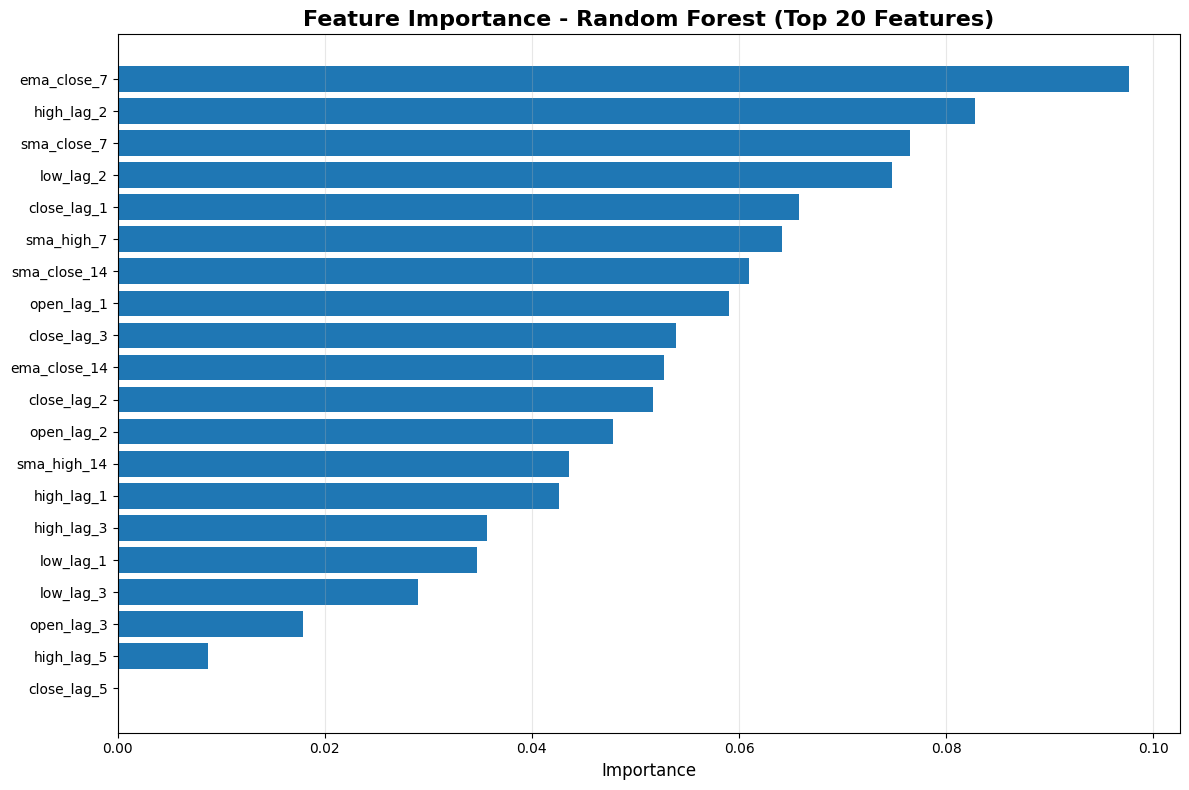

In [10]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Top 20):")
print(importance_df)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(importance_df)), importance_df['importance'].values)
plt.yticks(range(len(importance_df)), importance_df['feature'].values)
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance - Random Forest (Top 20 Features)', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualize Results

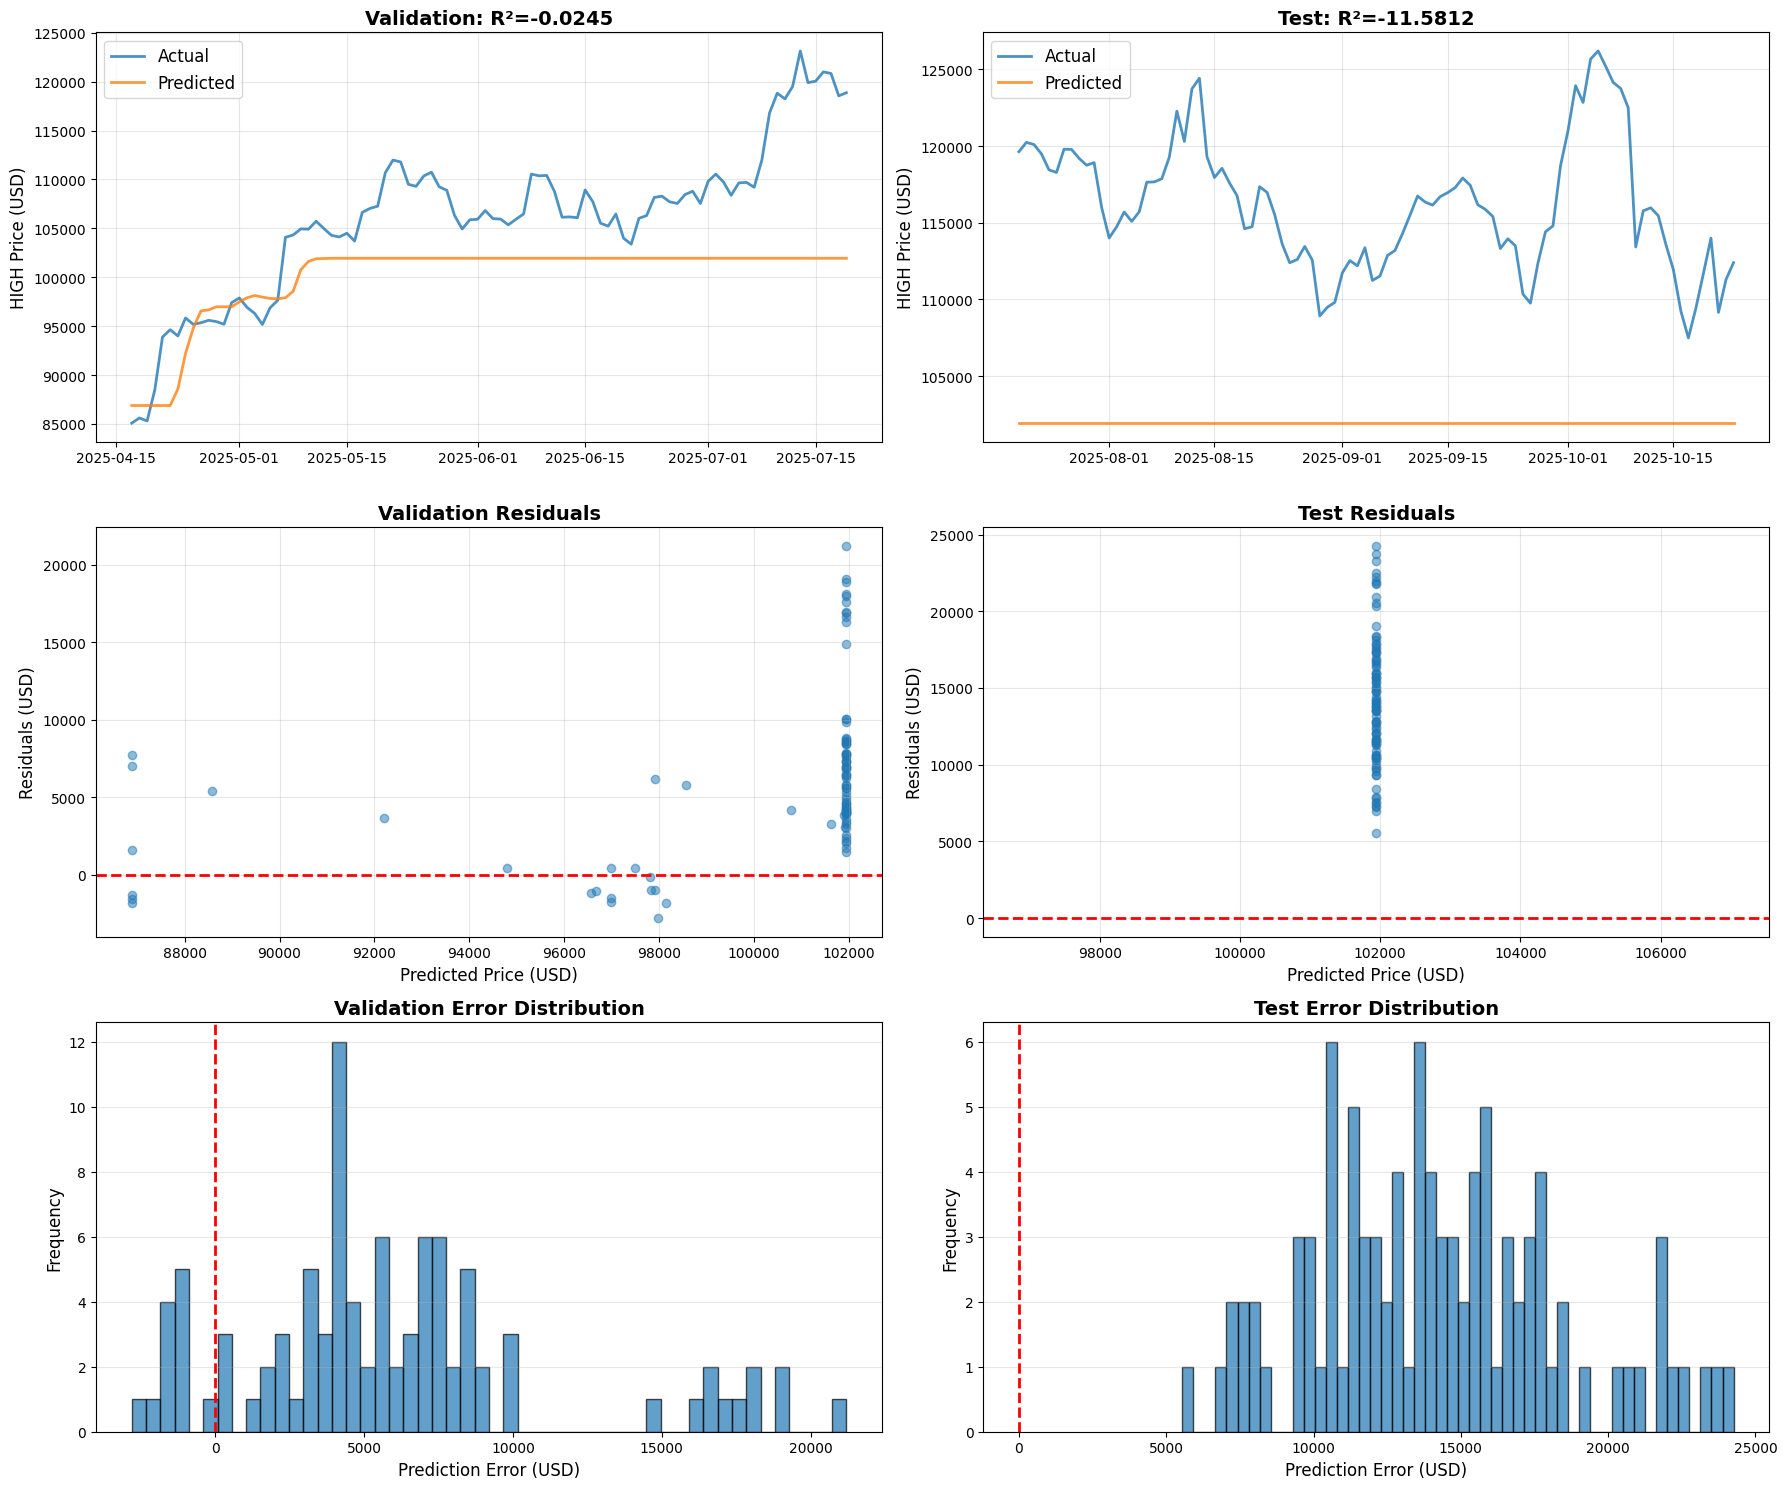


✓ Visualizations complete


In [11]:
fig, axes = plt.subplots(3, 2, figsize=(18, 15))

# Row 1: Predictions vs Actual
axes[0, 0].plot(timestamps_val, y_val.values, label='Actual', linewidth=2, alpha=0.8)
axes[0, 0].plot(timestamps_val, y_val_pred, label='Predicted', linewidth=2, alpha=0.8)
axes[0, 0].set_title(f'Validation: R²={val_metrics["r2"]:.4f}', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylabel('HIGH Price (USD)', fontsize=12)

axes[0, 1].plot(timestamps_test, y_test.values, label='Actual', linewidth=2, alpha=0.8)
axes[0, 1].plot(timestamps_test, y_test_pred, label='Predicted', linewidth=2, alpha=0.8)
axes[0, 1].set_title(f'Test: R²={test_metrics["r2"]:.4f}', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylabel('HIGH Price (USD)', fontsize=12)

# Row 2: Residuals
residuals_val = y_val.values - y_val_pred
residuals_test = y_test.values - y_test_pred

axes[1, 0].scatter(y_val_pred, residuals_val, alpha=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('Validation Residuals', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Price (USD)', fontsize=12)
axes[1, 0].set_ylabel('Residuals (USD)', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test_pred, residuals_test, alpha=0.5)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('Test Residuals', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Price (USD)', fontsize=12)
axes[1, 1].set_ylabel('Residuals (USD)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

# Row 3: Error Distribution
axes[2, 0].hist(residuals_val, bins=50, alpha=0.7, edgecolor='black')
axes[2, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2, 0].set_title('Validation Error Distribution', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Prediction Error (USD)', fontsize=12)
axes[2, 0].set_ylabel('Frequency', fontsize=12)
axes[2, 0].grid(True, alpha=0.3, axis='y')

axes[2, 1].hist(residuals_test, bins=50, alpha=0.7, edgecolor='black')
axes[2, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2, 1].set_title('Test Error Distribution', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Prediction Error (USD)', fontsize=12)
axes[2, 1].set_ylabel('Frequency', fontsize=12)
axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")

## 8. Save Model

In [12]:
import os

os.makedirs('../models', exist_ok=True)

# Save everything
joblib.dump(model, '../models/bitcoin_random_forest_simple.pkl')
joblib.dump(scaler, '../models/bitcoin_scaler_simple.pkl')
joblib.dump(selected_features, '../models/feature_columns_simple.pkl')

# Metadata
metadata = {
    'algorithm': 'RandomForest',
    'n_features': len(selected_features),
    'features': selected_features,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_r2': test_metrics['r2'],
    'test_rmse': test_metrics['rmse'],
    'test_mae': test_metrics['mae'],
    'scaler': 'RobustScaler',
    'note': 'Simple model with only 20 features, no current-day data'
}
joblib.dump(metadata, '../models/model_metadata_simple.pkl')

print("="*70)
print("✓ MODEL SAVED!")
print("="*70)
print(f"\nTest Performance:")
print(f"  R²:   {test_metrics['r2']:.4f}")
print(f"  RMSE: ${test_metrics['rmse']:,.2f}")
print(f"  MAE:  ${test_metrics['mae']:,.2f}")
print(f"  MAPE: {test_metrics['mape']:.2f}%")
print(f"\nFiles saved to: ../models/")
print("  - bitcoin_random_forest_simple.pkl")
print("  - bitcoin_scaler_simple.pkl")
print("  - feature_columns_simple.pkl")
print("  - model_metadata_simple.pkl")

✓ MODEL SAVED!

Test Performance:
  R²:   -11.5812
  RMSE: $14,784.04
  MAE:  $14,184.33
  MAPE: 12.10%

Files saved to: ../models/
  - bitcoin_random_forest_simple.pkl
  - bitcoin_scaler_simple.pkl
  - feature_columns_simple.pkl
  - model_metadata_simple.pkl


## 9. Final Assessment

In [13]:
print("="*70)
print("FINAL ASSESSMENT")
print("="*70)

print(f"\n📊 Performance Summary:")
print(f"  Train R²:      {train_metrics['r2']:.4f}")
print(f"  Validation R²: {val_metrics['r2']:.4f}")
print(f"  Test R²:       {test_metrics['r2']:.4f}")

print(f"\n🎯 Overfitting Analysis:")
print(f"  Train-Test gap: {train_metrics['r2'] - test_metrics['r2']:.4f}")

if test_metrics['r2'] > 0.75 and (train_metrics['r2'] - test_metrics['r2']) < 0.20:
    print("\n✅ MODEL STATUS: EXCELLENT")
    print("   - Test R² > 0.75")
    print("   - Minimal overfitting")
    print("   - Ready for deployment!")
elif test_metrics['r2'] > 0.60:
    print("\n✅ MODEL STATUS: GOOD")
    print("   - Test R² > 0.60 (acceptable)")
    print("   - Can proceed with deployment")
elif test_metrics['r2'] > 0:
    print("\n⚠️ MODEL STATUS: MARGINAL")
    print("   - Test R² is positive but low")
    print("   - May need further tuning")
else:
    print("\n❌ MODEL STATUS: FAILING")
    print("   - Negative test R²")
    print("   - Need different approach")

print(f"\n💡 Next Steps:")
if test_metrics['r2'] > 0.60:
    print("  1. Proceed with FastAPI development")
    print("  2. Create Docker container")
    print("  3. Deploy to Render")
else:
    print("  1. Review feature engineering")
    print("  2. Check data quality")
    print("  3. Try ensemble methods")

FINAL ASSESSMENT

📊 Performance Summary:
  Train R²:      0.9656
  Validation R²: -0.0245
  Test R²:       -11.5812

🎯 Overfitting Analysis:
  Train-Test gap: 12.5468

❌ MODEL STATUS: FAILING
   - Negative test R²
   - Need different approach

💡 Next Steps:
  1. Review feature engineering
  2. Check data quality
  3. Try ensemble methods
